In [1]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = './gdrive/My Drive/Colab Notebooks/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Importação das bibliotecas necessárias**

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix,classification_report
import itertools
from keras.optimizers import Adam


Using TensorFlow backend.


**Carregando os dados e suas respectivas labels**

In [3]:
#Base de dados completa
data = pd.read_csv(root_path+'tarefa_lcc/bd/base_ecg.csv', header=None).values
print(data.shape)

#Labels
labels= pd.read_csv(root_path+'tarefa_lcc/bd/labels_ecg.csv', header=None).values
print(labels.shape)

#Quantidade de exemplos por classe
#print(labels[0].value_counts())

(1000, 1025)
(1000, 1)


**Criando os sub-datasets de treino e teste**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)

#Shape do dataset e labels de treino
print("Shape do X do treino {}".format(X_train.shape))
print("Shape do Y do treino {}".format(y_train.shape))
print('---------------------------------------------------------')
#Shape do dataset e labels de teste
print("Shape do X do teste {}".format(X_test.shape))
print("Shape do Y do teste {}".format(y_test.shape))

#Adicionando outra dimensão
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

print("Novo Shape do X do treino {}".format(X_train.shape))
print("Novo Shape do X do teste {}".format(X_test.shape))

#Transformando uma label em matriz de labels
ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1,1))
y_test = ohe.transform(y_test.reshape(-1,1))

print("Novo Shape do Y do treino {}".format(y_train.shape))
print("Novo Shape do Y do teste {}".format(y_test.shape))



Shape do X do treino (700, 1025)
Shape do Y do treino (700, 1)
---------------------------------------------------------
Shape do X do teste (300, 1025)
Shape do Y do teste (300, 1)
Novo Shape do X do treino (700, 1025, 1)
Novo Shape do X do teste (300, 1025, 1)
Novo Shape do Y do treino (700, 17)
Novo Shape do Y do teste (300, 17)


**CNN - Convolutional Neural Network**

---


***Definição do modelo utilizado***

Taxa de aprendizado

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:

def network(X_train,y_train,X_test,y_test):
    
    im_shape=(X_train.shape[1],1)
    
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    
    conv4_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool3)
    conv4_1=BatchNormalization()(conv4_1)
    pool4=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)
    

    flatten=Flatten()(pool4)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(17, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer=Adam(lr=lr_schedule(0)), loss='categorical_crossentropy',metrics = ['accuracy'])
    
    

    history=model.fit(X_train, y_train,epochs=150, batch_size=32,validation_data=(X_test,y_test))
    return(model,history)



---
Avaliação


In [0]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.title('Modelo - Acurácia')
    plt.legend(['Treino', 'Teste'], loc='lower right')
    #plt.show()
    plt.savefig(root_path+"/"+"tarefa_lcc/acuracia.png", format='png')
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Época')
    plt.ylabel('Loss')
    plt.title('Modelo- Loss')
    plt.legend(['Treino', 'Teste'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12', '13', '14', '15', '16','17']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [9]:
model,history=network(X_train,y_train,X_test,y_test)

Learning rate:  0.001
Train on 700 samples, validate on 300 samples
Epoch 1/150
700/700 [==============================] - 5s 7ms/step - loss: 2.0498 - accuracy: 0.4029 - val_loss: 2.7692 - val_accuracy: 0.1367
Epoch 2/150
700/700 [==============================] - 4s 6ms/step - loss: 1.2493 - accuracy: 0.6571 - val_loss: 2.7032 - val_accuracy: 0.2800
Epoch 3/150
700/700 [==============================] - 4s 6ms/step - loss: 0.9180 - accuracy: 0.7300 - val_loss: 2.6538 - val_accuracy: 0.2800
Epoch 4/150
700/700 [==============================] - 4s 5ms/step - loss: 0.7187 - accuracy: 0.7857 - val_loss: 2.6209 - val_accuracy: 0.2800
Epoch 5/150
700/700 [==============================] - 4s 6ms/step - loss: 0.5862 - accuracy: 0.8414 - val_loss: 2.6323 - val_accuracy: 0.2800
Epoch 6/150
700/700 [==============================] - 4s 6ms/step - loss: 0.4147 - accuracy: 0.8900 - val_loss: 2.6673 - val_accuracy: 0.2800
Epoch 7/150
700/700 [==============================] - 4s 6ms/step - loss:

Accuracy: 87.00%


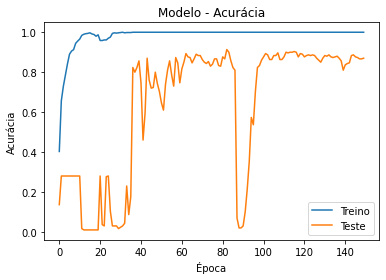

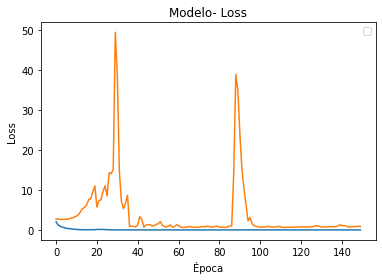

In [17]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

**Resultados de Precision, recall e f1-score**

In [18]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.98      0.87        84
           1       1.00      0.58      0.73        26
           2       1.00      0.78      0.88         9
           3       0.91      0.91      0.91        32
           4       0.00      0.00      0.00         2
           5       0.83      0.91      0.87        11
           6       0.82      0.80      0.81        41
           7       0.76      0.93      0.84        14
           8       1.00      1.00      1.00         3
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       1.00      0.67      0.80         3
          13       0.97      0.97      0.97        29
          14       1.00      0.75      0.86        24
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        14

    accuracy                           0.87       300
   macro avg       0.88   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matriz de confusão normalizada


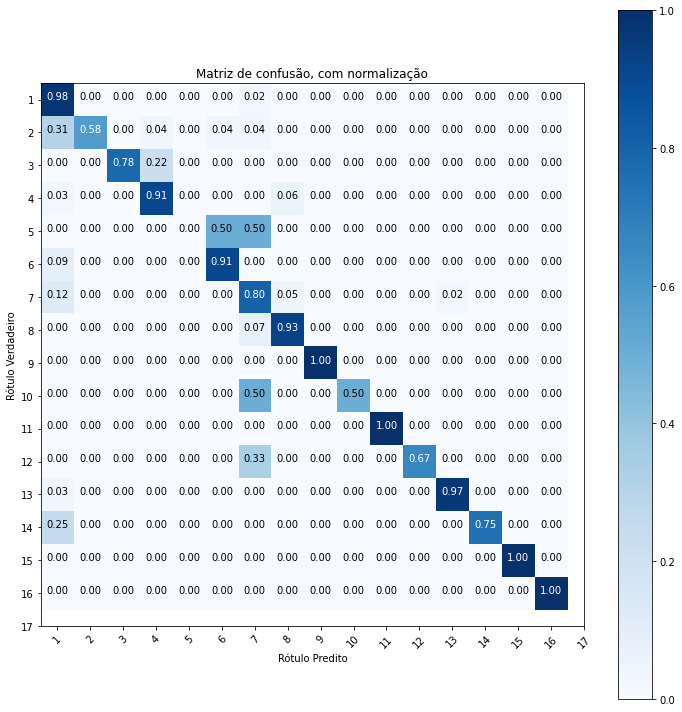

In [19]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Predito')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12', '13', '14', '15', '16','17'],normalize=True,
                      title='Matriz de confusão, com normalização')
plt.show()

Matriz de confusão, sem normalização


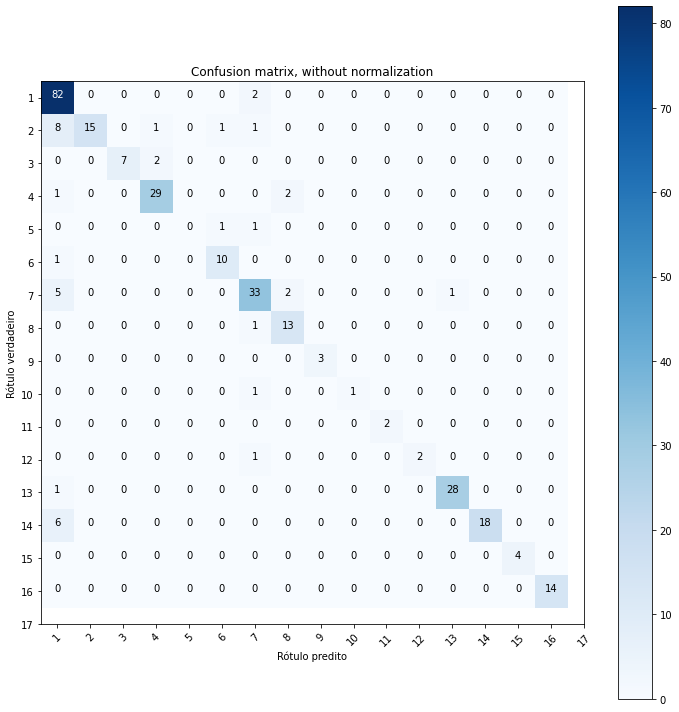

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusão normalizada")
    else:
        print('Matriz de confusão, sem normalização')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Rótulo verdadeiro')
    plt.xlabel('Rótulo predito')
    plt.savefig(root_path+"/"+"tarefa_lcc/matriz.png", format='png')
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['1', '2', '3', '4', '5','6', '7', '8', '9', '10','11','12', '13', '14', '15', '16','17'],
                      title='Confusion matrix, without normalization')
plt.show()